## Import

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install -U textblob
!pip install googletrans

     |████████████████████████████████| 24.2MB 132kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.4)
Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 983kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=f602c549b8d3c158d43f1b20a47fb39a769885bb21537f2b6aa7ddf832a77c32
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0

In [102]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#translate
from textblob import TextBlob as tb
from googletrans import Translator

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Sentimental

## kaggle

In [3]:
 ! pip install -q kaggle

In [4]:
 ! mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d kazanova/sentiment140

 94% 76.0M/80.9M [00:00<00:00, 84.4MB/s]
100% 80.9M/80.9M [00:00<00:00, 111MB/s] 


In [8]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


## Dataset

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [11]:
dataset_path = "training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df

target  ...                                               text
0             0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1             0  ...  is upset that he can't update his Facebook by ...
2             0  ...  @Kenichan I dived many times for the ball. Man...
3             0  ...    my whole body feels itchy and like its on fire 
4             0  ...  @nationwideclass no, it's not behaving at all....
...         ...  ...                                                ...
1599995       4  ...  Just woke up. Having no school is the best fee...
1599996       4  ...  TheWDB.com - Very cool to hear old Walt interv...
1599997       4  ...  Are you ready for your MoJo Makeover? Ask me f...
1599998       4  ...  Happy 38th Birthday to my boo of alll time!!! ...
1599999       4  ...  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 6 columns]

In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [13]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 452 ms, sys: 670 µs, total: 452 ms
Wall time: 452 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

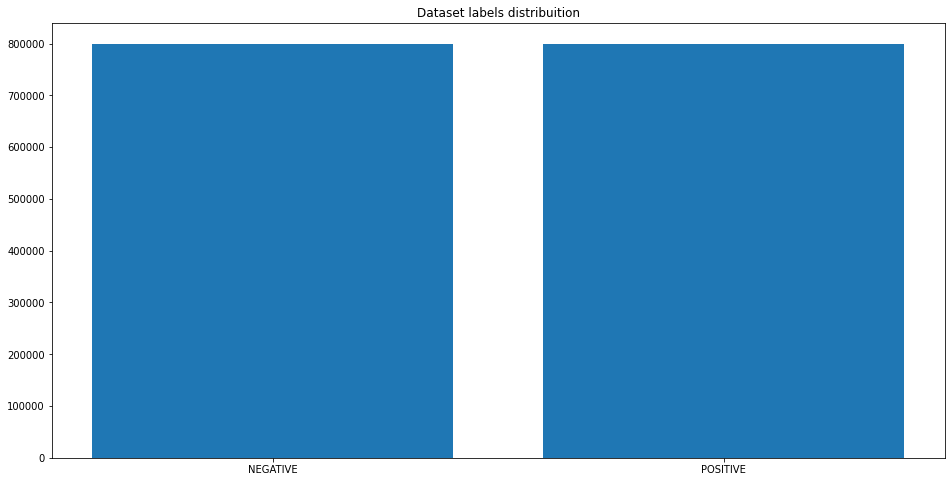

In [65]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Pre-processing

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 42 s, sys: 119 ms, total: 42.1 s
Wall time: 42.2 s


split train/test

In [18]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


word2vec

In [19]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 2.41 s, sys: 287 ms, total: 2.7 s
Wall time: 2.7 s


In [20]:
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/word.w2v")

2020-11-21 09:59:40,981 : INFO : loading Word2Vec object from /content/drive/MyDrive/word.w2v
2020-11-21 09:59:44,451 : INFO : loading wv recursively from /content/drive/MyDrive/word.w2v.wv.* with mmap=None
2020-11-21 09:59:44,453 : INFO : setting ignored attribute vectors_norm to None
2020-11-21 09:59:44,454 : INFO : loading vocabulary recursively from /content/drive/MyDrive/word.w2v.vocabulary.* with mmap=None
2020-11-21 09:59:44,460 : INFO : loading trainables recursively from /content/drive/MyDrive/word.w2v.trainables.* with mmap=None
2020-11-21 09:59:44,461 : INFO : setting ignored attribute cum_table to None
2020-11-21 09:59:44,463 : INFO : loaded /content/drive/MyDrive/word.w2v


In [21]:
# w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
#                                             window=W2V_WINDOW, 
#                                             min_count=W2V_MIN_COUNT, 
#                                             workers=8)

In [22]:
# w2v_model.build_vocab(documents)

In [23]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [24]:
%%time
# w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 25.7 µs


In [25]:
w2v_model.most_similar("win")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-21 09:59:44,569 : INFO : precomputing L2-norms of word weight vectors


[('winning', 0.5556814670562744),
 ('wins', 0.5496399402618408),
 ('winner', 0.3982756733894348),
 ('lose', 0.3979034721851349),
 ('wristbands', 0.38986557722091675),
 ('nominations', 0.3815792202949524),
 ('rooting', 0.3757798373699188),
 ('djokovic', 0.3709818720817566),
 ('vettel', 0.3656772971153259),
 ('winners', 0.36259907484054565)]

## Tokenize Text

In [26]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 14.7 s, sys: 119 ms, total: 14.8 s
Wall time: 14.8 s


In [27]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 22 s, sys: 525 ms, total: 22.5 s
Wall time: 22.5 s


Label Encoder

In [28]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [29]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())
4
y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [30]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [31]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

Embedding layer

In [32]:
tokenizer.word_index.items()

dict_items([('good', 1), ('day', 2), ('get', 3), ('like', 4), ('go', 5), ('quot', 6), ('today', 7), ('work', 8), ('going', 9), ('love', 10), ('got', 11), ('lol', 12), ('time', 13), ('back', 14), ('u', 15), ('one', 16), ('know', 17), ('im', 18), ('really', 19), ('amp', 20), ('see', 21), ('night', 22), ('still', 23), ('2', 24), ('well', 25), ('new', 26), ('want', 27), ('think', 28), ('home', 29), ('thanks', 30), ('oh', 31), ('much', 32), ('miss', 33), ('need', 34), ('last', 35), ('morning', 36), ('tomorrow', 37), ('hope', 38), ('great', 39), ('twitter', 40), ('3', 41), ('haha', 42), ('feel', 43), ('sad', 44), ('fun', 45), ('wish', 46), ('sleep', 47), ('right', 48), ('would', 49), ('bad', 50), ('happy', 51), ('sorry', 52), ('tonight', 53), ('come', 54), ('make', 55), ('getting', 56), ('way', 57), ('though', 58), ('gonna', 59), ('nice', 60), ('better', 61), ('watching', 62), ('yeah', 63), ('bed', 64), ('wait', 65), ('could', 66), ('week', 67), ('school', 68), ('people', 69), ('hate', 70), 

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [35]:
embedding_layer

## load model

In [36]:
model = load_model('/content/drive/My Drive/model.h5')
# summarize model.
model.summary()

2020-11-21 10:00:30,709 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


## Build Model

In [37]:
# model = Sequential()
# model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

Compile model

In [38]:
# model.compile(loss='binary_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy'])

Callbacks

In [39]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Train

In [40]:
# %%time
# history = model.fit(x_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_split=0.1,
#                     verbose=1,
#                     callbacks=callbacks)

Evaluate

In [41]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 63s 203ms/step - loss: 0.4503 - accuracy: 0.7891

ACCURACY: 0.7891250252723694
LOSS: 0.45026445388793945
CPU times: user 53.2 s, sys: 8.14 s, total: 1min 1s
Wall time: 1min 6s


In [42]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
 
# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
 
# plt.show()

Predict

In [43]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [51]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [45]:
predict("I love the music")

{'elapsed_time': 0.2964212894439697,
 'label': 'POSITIVE',
 'score': 0.9646057486534119}

In [46]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.09572911262512207,
 'label': 'NEGATIVE',
 'score': 0.21940656006336212}

In [47]:
predict("bjp will fall")

{'elapsed_time': 0.10310745239257812,
 'label': 'NEGATIVE',
 'score': 0.36581680178642273}

In [48]:
predict("BJPs chances of winning are very low")

{'elapsed_time': 0.09472513198852539,
 'label': 'NEGATIVE',
 'score': 0.19663472473621368}

## Confusion Matrix

In [ ]:
# %%time
# y_pred_1d = []
# y_test_1d = list(df_test.target)
# scores = model.predict(x_test, verbose=1, batch_size=8000)
# y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """

#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=30)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
#     plt.yticks(tick_marks, classes, fontsize=22)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label', fontsize=25)
#     plt.xlabel('Predicted label', fontsize=25)

In [ ]:
# %%time

# cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
# plt.figure(figsize=(12,12))
# plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
# plt.show()

## Classification Report

In [52]:
print(classification_report(y_test_1d, y_pred_1d))

ValueError: ignored

Accuracy Score

In [53]:
accuracy_score(y_test_1d, y_pred_1d)

ValueError: ignored

Save model

In [ ]:
# model.save('/content/drive/My Drive/model.h5')
# w2v_model.save('/content/drive/My Drive/word.w2v')
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

## test

In [54]:
predict("BJP leader's sons broke journalist's hands and said, now where did weep on Arnab's arrest")

{'elapsed_time': 0.1185605525970459,
 'label': 'NEGATIVE',
 'score': 0.04994397237896919}

In [55]:
txt="हरियाणा में की खट्टर सरकार ने की फ़ीस 50% तक बढ़ाई,44 लाख चाहिए अब डॉक्टर बनने के लिए,क्यों BJP सब से पकौड़े ही बिकवाना चाहती है? या फिर अब ग़रीब का बच्चा डॉक्टर नहीं बन पाएगा? "
predict(str((tb(txt)).translate(to="en")))

{'elapsed_time': 0.13063526153564453,
 'label': 'NEGATIVE',
 'score': 0.010532693937420845}

# Prediction

In [131]:
with open('cpi.txt',"rb") as fp:
    q = pickle.load(fp)

In [132]:
%%time
senti = []
score = []
for i in q:
    temp = list(predict(i).values())
    senti.append(temp[0])
    score.append(temp[1])

CPU times: user 1min, sys: 922 ms, total: 1min 1s
Wall time: 1min 1s


In [58]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    for key, value in freq.items(): 
        print ("% s : % d"%(key, value)) 
    return freq

In [112]:
b = CountFrequency(senti)

NEUTRAL :  706
NEGATIVE :  180
POSITIVE :  334


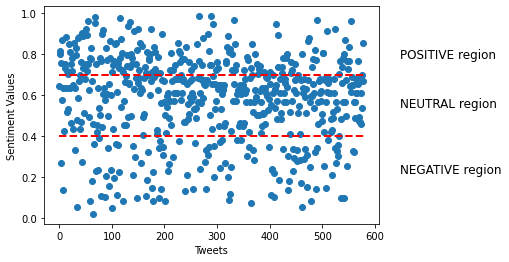

In [154]:
plt.scatter(np.arange(0,len(score)),score)
plt.plot([0,len(score)],[0.4,0.4],color="red",linewidth=2,linestyle='dashed')
plt.plot([0,len(score)],[0.7,0.7],color="red",linewidth=2,linestyle='dashed')
plt.xlabel("Tweets")
plt.ylabel("Sentiment Values")
plt.figtext(0.95, 0.7, "POSITIVE region", fontsize = 12)
plt.figtext(0.95, 0.3, "NEGATIVE region", fontsize = 12) 
plt.figtext(0.95, 0.53, "NEUTRAL region", fontsize = 12) 
plt.show()

### graphs

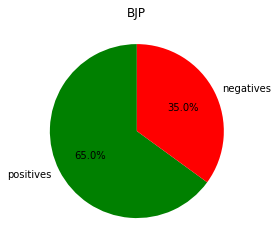

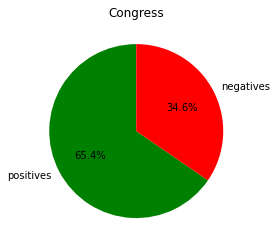

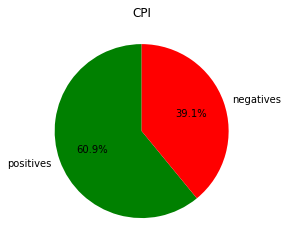

<Figure size 432x288 with 0 Axes>

In [113]:
#import matplotlib.pyplot as plt

category = ['positives', 'negatives']
colors = ['g', 'r']

slices_b = [b['POSITIVE'], b['NEGATIVE']]
slices_con = [con['POSITIVE'], con['NEGATIVE']]
slices_cpi = [cpi['POSITIVE'], cpi['NEGATIVE']]

plt.figure()
plt.pie(slices_b, labels=category, colors=colors, startangle=90, autopct='%.1f%%')
plt.title("BJP")
plt.figure()
plt.pie(slices_con, labels=category, colors=colors, startangle=90, autopct='%.1f%%')
plt.title("Congress")
plt.figure()
plt.pie(slices_cpi, labels=category, colors=colors, startangle=90, autopct='%.1f%%')
plt.title("CPI")
plt.figure()

plt.show()

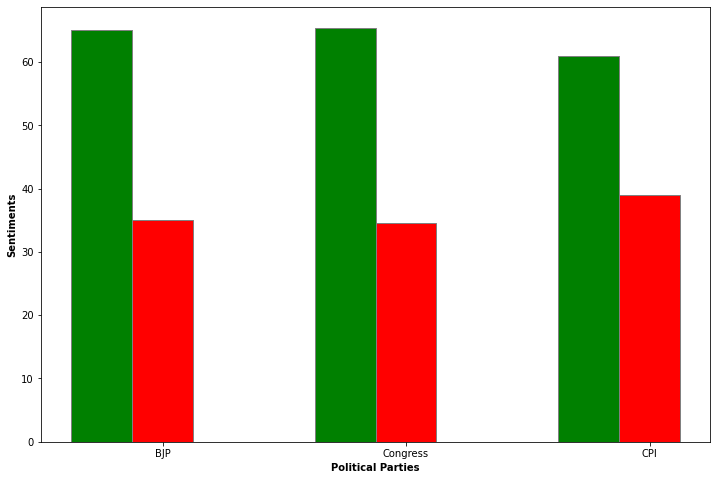

In [165]:
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
   
# set height of bar 
pos = [bjp, congress, communist] 
neg = [100-bjp, 100-congress, 100-communist] 
   
# Set position of bar on X axis 
br1 = np.arange(len(pos)) 
br2 = [x + barWidth for x in br1] 
   
# Make the plot 
plt.bar(br1, pos, color ='g', width = barWidth, 
        edgecolor ='grey', label ='positive') 
plt.bar(br2, neg, color ='r', width = barWidth, 
        edgecolor ='grey', label ='negative') 
   
# Adding Xticks  
plt.xlabel('Political Parties', fontweight ='bold') 
plt.ylabel('Sentiments', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(pos))], 
           ['BJP', 'Congress', 'CPI']) 
   
plt.show()

In [101]:
final_dic = Counter(cpi) + Counter(b) + Counter(con)
final=final_dic['POSITIVE']+final_dic['NEGATIVE']

### New Section

In [162]:
bjp = (b['POSITIVE']/(b['NEGATIVE']+b['POSITIVE']))*100
bjp

64.98054474708171

In [163]:
congress = (con['POSITIVE']/(con['NEGATIVE']+con['POSITIVE']))*100
congress

65.42056074766354

In [164]:
communist = (cpi['POSITIVE']/(cpi['NEGATIVE']+cpi['POSITIVE']))*100
communist

60.94276094276094

### weird logic

In [91]:
(b['POSITIVE']+con['NEGATIVE']+cpi['NEGATIVE'])/final

0.495583038869258

In [86]:
(b['NEGATIVE']+con['POSITIVE']+cpi['NEGATIVE'])/final

0.4469964664310954

In [87]:
(b['NEGATIVE']+con['NEGATIVE']+cpi['POSITIVE'])/final

0.4169611307420495